In [24]:
import numpy as np
import matplotlib.pyplot as plt

import SMBHBpy
from SMBHBpy import constants as c
from SMBHBpy import merger_system as ms

from scipy.interpolate import interp1d

The code works in geometrized units with $c=G=1$, which means that energy, length, time, and mass all have the same units (see for example $E=mc^2 = m$, and $1 = c = \text{length}/\text{time}$)

We can choose which unit we want to describe them with, and usually parsecs is chosen ($1$ pc$\, \approx 3.26$ ly$\,\approx 3.09\cdot 10^{16}$ m). To this end, the SMBHBpy.constants file has a few constants for the transformation.

### Define the SMBH binary

In [25]:
m_array = np.array([1e6,1e8])*c.solar_mass_to_pc
m1 =  9*1e7 * c.solar_mass_to_pc               # Mass of the first SMBH
m2 =  9*1e7 * c.solar_mass_to_pc               # Mass of the second SMBH

D_luminosity = 65*1e6                          # Luminosity distance to the system from earth [pc]

sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)       # Velocity dispersion of the host galaxy-bulge [km/s]
b_max = 10  *10**3                             # Maximum impact parameter (Coulomb logarithm) [kpc]

# k: Indicates whether the halos are static halos (k = 0) or non-static/rotating halos (k=1),
# k = 0 can be selected independently of the eccentricity, k = 1 only if circular orbits are involved.
# (https://doi.org/10.21248/gups.79949)
k = 0.

### Define dark matter halo properties

In [26]:
# For equal-mass SMBHs!
# (https://arxiv.org/abs/1408.3534, https://arxiv.org/abs/1402.0005)

alpha_CDM = 7./3.
alpha_SIDM = 7./4.

r_sp_array = np.array([0.2*m_array[0]/sigma**2, 0.2*m_array[1]/sigma**2])
r_sp = 0.2*m1/sigma**2

rho_sp_CDM_array = np.array([(3-alpha_CDM)*0.2**(3-alpha_CDM)*m_array[0]/(2*np.pi*r_sp_array[0]**3), (3-alpha_CDM)*0.2**(3-alpha_CDM)*m_array[1]/(2*np.pi*r_sp_array[1]**3)])
rho_sp_SIDM_array = np.array([(3-alpha_SIDM)*0.2**(3-alpha_SIDM)*m_array[0]/(2*np.pi*r_sp_array[0]**3), (3-alpha_SIDM)*0.2**(3-alpha_SIDM)*m_array[1]/(2*np.pi*r_sp_array[1]**3)])

rho_sp_CDM = (3-alpha_CDM)*0.2**(3-alpha_CDM)*m1/(2*np.pi*r_sp**3)
rho_sp_SIDM = (3-alpha_SIDM)*0.2**(3-alpha_SIDM)*m1/(2*np.pi*r_sp**3)

spike_CDM_list = [SMBHBpy.halo.Spike(rho_sp_CDM_array[0], r_sp_array[0], alpha_CDM), SMBHBpy.halo.Spike(rho_sp_CDM_array[1], r_sp_array[1], alpha_CDM)]
spike_SIDM_list = [SMBHBpy.halo.Spike(rho_sp_SIDM_array[0], r_sp_array[0], alpha_SIDM), SMBHBpy.halo.Spike(rho_sp_SIDM_array[1], r_sp_array[1], alpha_SIDM)]

spike_CDM = SMBHBpy.halo.Spike(rho_sp_CDM, r_sp, alpha_CDM)
spike_SIDM = SMBHBpy.halo.Spike(rho_sp_SIDM, r_sp, alpha_SIDM)

# For GW-only, i.e., no spikes around the SMBHs, for comparison
no_spike_GW = SMBHBpy.halo.ConstHalo(0.)

In [27]:
# NFW profile for comparison (https://arxiv.org/pdf/2303.12107.pdf, https://arxiv.org/abs/astro-ph/9611107)
r_s = 18.6*1e3
R_sun = 8200
rho_s = 0.009 * c.solar_mass_to_pc * (R_sun/r_s)*(1+R_sun/r_s)**2
nfw = SMBHBpy.halo.NFW(rho_s, r_s)

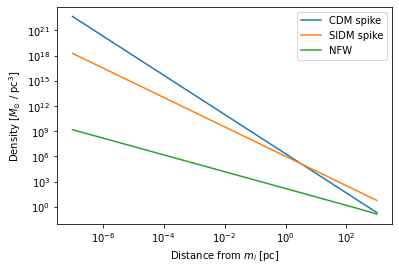

In [28]:
# Plot density distributions
r_grid = np.geomspace(10e-8, 1e3, 100)  # creates a grid in pc
plt.loglog(r_grid, spike_CDM.density(r_grid)/c.solar_mass_to_pc, label='CDM spike')
plt.loglog(r_grid, spike_SIDM.density(r_grid)/c.solar_mass_to_pc, label='SIDM spike')
plt.loglog(r_grid, nfw.density(r_grid)/c.solar_mass_to_pc, label='NFW')
plt.xlabel("Distance from $m_i$ [pc]"); plt.ylabel("Density [$M_{\odot}$ / pc$^3$]"); plt.legend(); plt.show()

### Define initial conditions for a circular inspiral

In [29]:
# Create the SystemProp object describing the SMBH binary with static CDM halos (k = 0)
sp_CDM_list = [ms.SystemProp(m_array[0], m_array[0], spike_CDM_list[0], spike_CDM_list[0], sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2),ms.SystemProp(m_array[1], m_array[1], spike_CDM_list[1], spike_CDM_list[1], sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2)]
sp_CDM = ms.SystemProp(m1, m2, spike_CDM, spike_CDM, sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2)
sp = sp_CDM
sp_list = [sp_CDM_list[0],sp_CDM_list[1]]

# Create the SystemProp object describing the SMBH binary with static SIDM halos (k = 0)
sp_SIDM_list = [ms.SystemProp(m_array[0], m_array[0], spike_SIDM_list[0], spike_SIDM_list[0], sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2),ms.SystemProp(m_array[1], m_array[1], spike_SIDM_list[1], spike_SIDM_list[1], sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2)]
sp_SIDM = ms.SystemProp(m1, m2, spike_SIDM, spike_SIDM, sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2)

# For GW-only, i.e., no spikes around the SMBHs, for comparison
sp_GW_list = [ms.SystemProp(m_array[0], m_array[0], no_spike_GW, no_spike_GW, sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2),ms.SystemProp(m_array[1], m_array[1], no_spike_GW, no_spike_GW, sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2)]
sp_GW = ms.SystemProp(m1, m2, no_spike_GW, no_spike_GW, sigma, b_max, k, D=D_luminosity, inclination_angle = np.pi/2)

# Adjust N according to mass (cf. table, only for equal masses, https://doi.org/10.21248/gups.79949)! 
# Explanation: 35 days to r_isco_1+r_isco_2 corresponds to a distance of N*(r_isco_1+r_isco_2)
N =      2.87

# N           12.3     6.65        5.0        4.2       3.73         3.41         3.18          3.0         2.87         2.75   
# m1=m2=m     10^7   2.0*10^7   3.0*10^7   4.0*10^7   5.0*10^7     6.0*10^7     7.0*10^7     8.0*10^7     9.0*10^7     1.0*10^8 


R0_array = np.array([50 * (sp_list[0].r_isco_1()+sp_list[0].r_isco_2()),50 * (sp_list[1].r_isco_1()+sp_list[1].r_isco_2())])
R0 = 50 * (sp.r_isco_1()+sp.r_isco_2())      # Initial separation
R_fin_array = np.array([sp_list[0].r_isco_1()+sp_list[0].r_isco_2(),sp_list[1].r_isco_1()+sp_list[1].r_isco_2()])
R_fin = sp.r_isco_1()+sp.r_isco_2()          # The final condition for the evolution

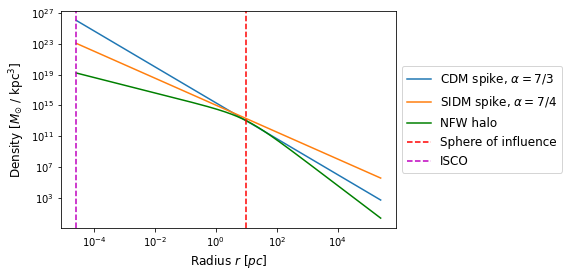

In [30]:
# Density profiles for different typs of matter
m = 9.0*1e7 * c.solar_mass_to_pc
sigma = 200 *10**3*c.m_to_pc/(c.s_to_pc)
r_sp = 0.2*m/sigma**2
r_s = m/sigma**2
r_isco = 6*m
rho_sp_CDM = (3-7/3)*0.2**(3-7/3)*m/(2*np.pi*r_sp**3)
rho_sp_SIDM = (3-7/4)*0.2**(3-7/4)*m/(2*np.pi*r_sp**3)
rho_s = 4*0.2**(7/3)*rho_sp_CDM
r_ = np.geomspace(r_isco, 1e10*r_isco, 1000)
rho_CDM = rho_sp_CDM * (r_sp/r_)**(7/3)
rho_SIDM = rho_sp_SIDM * (r_sp/r_)**(7/4)
nfw = SMBHBpy.halo.NFW(rho_s, r_s)
rho_NFW = nfw.density(r_)
plt.loglog(r_, rho_CDM/c.solar_mass_to_pc*1e9, label='CDM spike, $\u03B1 = 7/3$')
plt.loglog(r_, rho_SIDM/c.solar_mass_to_pc*1e9, label='SIDM spike, $\u03B1 = 7/4$')
plt.loglog(r_, rho_NFW/c.solar_mass_to_pc*1e9, label='NFW halo', color = "green")
plt.axvline(x=m/sigma**2, linestyle='--', label = "Sphere of influence", color = "red")
plt.axvline(x=r_isco, linestyle='--', label = "ISCO", color = "m")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.xlabel("Radius $r$ [$pc$]", fontsize=12); plt.ylabel("Density [$M_{\odot}$ / kpc$^3$]", fontsize=12)
plt.show()

### Solve the differential equations for circular orbits

In [31]:
# Solve the differential equations for static CDM halos (k = 0)
ev_CDM_list = [SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[0], R0_array[0], a_fin = R_fin_array[0]),SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[1], R0_array[1], a_fin = R_fin_array[1])]
ev_CDM = SMBHBpy.inspiral.Classic.Evolve(sp_CDM, R0, a_fin = R_fin)

# Solve the differential equations for static SIDM halos (k = 0)
ev_SIDM_list = [SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[0], R0_array[0], a_fin = R_fin_array[0]),SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[1], R0_array[1], a_fin = R_fin_array[1])]
ev_SIDM = SMBHBpy.inspiral.Classic.Evolve(sp_SIDM, R0, a_fin = R_fin)

# For GW-only, i.e., no spikes around the SMBHs, for comparison
ev_GW_list = [SMBHBpy.inspiral.Classic.Evolve(sp_GW_list[0], R0_array[0], a_fin = R_fin_array[0]),SMBHBpy.inspiral.Classic.Evolve(sp_GW_list[1], R0_array[1], a_fin = R_fin_array[1])]
ev_GW = SMBHBpy.inspiral.Classic.Evolve(sp_GW, R0, a_fin = R_fin)

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.0756s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.0644s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.0666s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 0.1117s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2   on circular orbits  with  Options: dissipative Forces emplyed {GWLoss, Dynamica

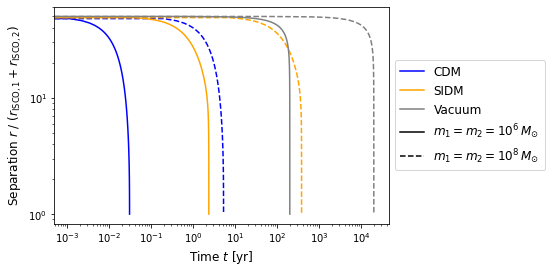

In [32]:
# Plot the results
plt.loglog(ev_CDM_list[0].t/c.year_to_pc, ev_CDM_list[0].R/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = "CDM", color = "blue")
plt.loglog(ev_CDM_list[1].t/c.year_to_pc, ev_CDM_list[1].R/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), color = "blue", linestyle = "dashed")
plt.loglog(ev_SIDM_list[0].t/c.year_to_pc, ev_SIDM_list[0].R/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = "SIDM", color = "orange")
plt.loglog(ev_SIDM_list[1].t/c.year_to_pc, ev_SIDM_list[1].R/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), color = "orange", linestyle = "dashed")
plt.loglog(ev_GW_list[0].t/c.year_to_pc, ev_GW_list[0].R/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = "Vacuum", color = "grey")
plt.loglog(ev_GW_list[1].t/c.year_to_pc, ev_GW_list[1].R/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), color = "grey", linestyle = "dashed")
plt.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^6 \, M_{\odot}$ ", linestyle="solid", color="black")
plt.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^8 \, M_{\odot}$ ", linestyle="dashed", color="black")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12); plt.xlabel("Time $t$ [yr]", fontsize=12); plt.ylabel("Separation $r$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=12)
plt.show()

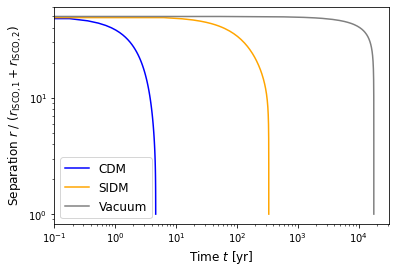

In [33]:
# Plot the results
plt.loglog(ev_CDM.t/c.year_to_pc, ev_CDM.R/(sp.r_isco_1()+sp.r_isco_2()), label = "CDM", color = "blue")
plt.loglog(ev_SIDM.t/c.year_to_pc, ev_SIDM.R/(sp.r_isco_1()+sp.r_isco_2()), label = "SIDM", color = "orange")
plt.loglog(ev_GW.t/c.year_to_pc, ev_GW.R/(sp.r_isco_1()+sp.r_isco_2()), label = "Vacuum", color = "grey")
plt.legend(loc = "lower left", fontsize=12); plt.xlabel("Time $t$ [yr]", fontsize=12); plt.ylabel("Separation $r$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=12)
plt.show()

In [34]:
# Total evolution time in days for static CDM halos (k = 0):
print("CDM:", ev_CDM.t[-1]/c.year_to_pc*365.25, "days")

# Total evolution time in days for static SIDM halos (k = 0):
print("SIDM:", ev_SIDM.t[-1]/c.year_to_pc*365.25, "days")

# Total evolution time in days for GW-only:
print("GW-only:", ev_GW.t[-1]/c.year_to_pc*365.25, "days")


#t_coal =  5./256. * R_fin**4/sp.m_total()**2 /sp.m_reduced()/c.year_to_pc*365.25
#print(t_coal)

CDM: 1697.5717398783718 days
SIDM: 122467.61905518099 days
GW-only: 6517637.256827648 days


### Calculate the gravitational wave signal

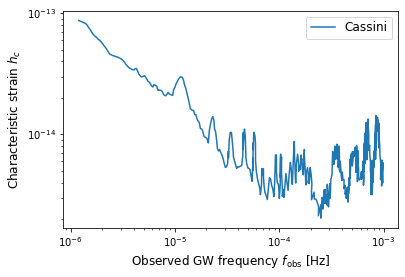

In [35]:
import pandas as pd

# Cassini data (https://ui.adsabs.harvard.edu/abs/2003ApJ...599..806A/abstract)
Cassini = pd.read_csv('cassini_hc.csv')
Cassini["f"] = 10**(Cassini["logf"])
Cassini["h_c"] = 10**(Cassini[" loghc"])
plt.loglog(Cassini["f"], Cassini["h_c"], label = "Cassini")

plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Characteristic strain $h_c$", fontsize=12); plt.legend(fontsize=12)
plt.show()

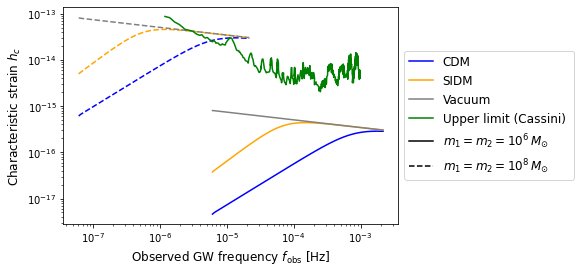

In [36]:
# The characteristic strain of the different GW signals compared to the GWB measured by Cassini

# CDM spikes:
f_gw_CDM_0, h_2_plus_CDM_0, h_2_cross_CDM_0, psi_CDM_0 = SMBHBpy.waveform.h_2(sp_CDM_list[0], ev_CDM_list[0])
f_gw_CDM_1, h_2_plus_CDM_1, h_2_cross_CDM_1, psi_CDM_1 = SMBHBpy.waveform.h_2(sp_CDM_list[1], ev_CDM_list[1])
plt.loglog(f_gw_CDM_0/c.hz_to_invpc, 2.* f_gw_CDM_0*h_2_plus_CDM_0, label="CDM", color = "blue")
plt.loglog(f_gw_CDM_1/c.hz_to_invpc, 2.* f_gw_CDM_1*h_2_plus_CDM_1, color = "blue", linestyle = "dashed")

# SIDM spikes:
f_gw_SIDM_0, h_2_plus_SIDM_0, h_2_cross_SIDM_0, psi_SIDM_0 = SMBHBpy.waveform.h_2(sp_SIDM_list[0], ev_SIDM_list[0])
f_gw_SIDM_1, h_2_plus_SIDM_1, h_2_cross_SIDM_1, psi_SIDM_1 = SMBHBpy.waveform.h_2(sp_SIDM_list[1], ev_SIDM_list[1])
plt.loglog(f_gw_SIDM_0/c.hz_to_invpc, 2.* f_gw_SIDM_0*h_2_plus_SIDM_0, label="SIDM", color = "orange")
plt.loglog(f_gw_SIDM_1/c.hz_to_invpc, 2.* f_gw_SIDM_1*h_2_plus_SIDM_1, color = "orange", linestyle = "dashed")

# For GW-only, i.e. no spikes around the SMBHs, for comparison
f_gw_GW_0, h_2_plus_GW_0, h_2_cross_GW_0, psi_GW_0 = SMBHBpy.waveform.h_2(sp_GW_list[0], ev_GW_list[0])
f_gw_GW_1, h_2_plus_GW_1, h_2_cross_GW_1, psi_GW_1 = SMBHBpy.waveform.h_2(sp_GW_list[1], ev_GW_list[1])
plt.loglog(f_gw_GW_0/c.hz_to_invpc, 2.* f_gw_GW_0*h_2_plus_GW_0, label="Vacuum", color = "grey")
plt.loglog(f_gw_GW_1/c.hz_to_invpc, 2.* f_gw_GW_1*h_2_plus_GW_1, color = "grey", linestyle = "dashed")

# Cassini (upper limit)
plt.loglog(Cassini["f"], Cassini["h_c"], label = "Upper limit (Cassini) ", color = "green")

plt.loglog(1e-5, 1e-14, label=r"$m_1 = m_2 = 10^6 \, M_{\odot}$ ", linestyle="solid", color="black")
plt.loglog(1e-5, 1e-14, label=r"$m_1 = m_2 = 10^8 \, M_{\odot}$ ", linestyle="dashed", color="black")

# LISA:
#Lisa = SMBHBpy.detector.Lisa()
#f_gw_LISA = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 500)
#plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA')

plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Characteristic strain $h_c$", fontsize=12)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
plt.show()

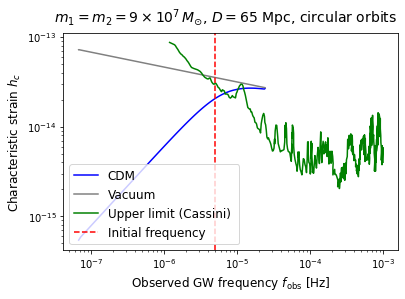

In [39]:
# The characteristic strain of the different GW signals compared to the GWB measured by Cassini for the appropriate values of D and m

# CDM spikes:
f_gw_CDM, h_2_plus_CDM, h_2_cross_CDM, psi_CDM = SMBHBpy.waveform.h_2(sp_CDM, ev_CDM)
plt.loglog(f_gw_CDM/c.hz_to_invpc, 2.* f_gw_CDM*h_2_plus_CDM, label="CDM", color = "blue")


# For GW-only, i.e. no spikes around the SMBHs, for comparison
f_gw_GW, h_2_plus_GW, h_2_cross_GW, psi_GW = SMBHBpy.waveform.h_2(sp_GW, ev_GW)
plt.loglog(f_gw_GW/c.hz_to_invpc, 2.* f_gw_GW*h_2_plus_GW, label="Vacuum", color = "grey")

# Cassini (upper limit)
plt.loglog(Cassini["f"], Cassini["h_c"], label = "Upper limit (Cassini) ", color = "green")

# LISA:
#Lisa = SMBHBpy.detector.Lisa()
#f_gw_LISA = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 500)
#plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA')

plt.suptitle("$m_1 = m_2 = 9 \\times 10^7 \, M_{\odot} $, $D = 65$ Mpc, circular orbits", y=0.97, fontsize=14)

plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Characteristic strain $h_c$", fontsize=12)


plt.axvline(x=1./(1+sp.z())*1/np.pi*np.sqrt(2*m1/(N*(sp.r_isco_1()+sp.r_isco_2()))**3)/c.hz_to_invpc, color='red', label="Initial frequency", linestyle='--')
plt.legend(loc = "lower left", fontsize=12)
plt.show()

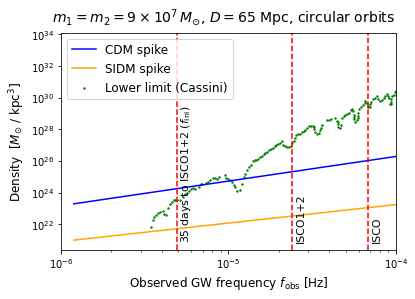

In [40]:
# Calculation of the density using the formula from https://doi.org/10.21248/gups.79949 for the appropriate values of D and m
m = m1
Lambda = b_max/sp.r_infl()
iota = sp.inclination_angle
D = D_luminosity
z = sp.z()
h_c = Cassini["h_c"]
f = Cassini["f"]*c.hz_to_invpc

A = 1./3.*1./2**(2./3.)*1./(np.log(Lambda))*((1+(np.cos(iota))**2)/D)**2*((1+z)**16*m**10*np.pi**4)**(1./3.)
B = 1./5.*1./(np.log(Lambda))*(2**8*(1+z)**11*m**5*np.pi**8)**(1./3.)

rho_DM = A*f**(10./3.)/(h_c**2)-B*f**(11./3.)
r = (2*m/(f*(1+z)*np.pi)**2)**(1./3.)

N = 2.87

#####

# Plot of the result in comparison with the spike profiles of different DM models (CDM + SIDM)
plt.scatter(f/c.hz_to_invpc, rho_DM/c.solar_mass_to_pc*1e9, s = 2, color = "green", label = "Lower limit (Cassini)")

plt.loglog(f/c.hz_to_invpc,rho_sp_CDM*(r_sp/r)**(7./3.)/c.solar_mass_to_pc*1e9, label = "CDM spike", color = "blue")
plt.loglog(f/c.hz_to_invpc,rho_sp_SIDM*(r_sp/r)**(7./4.)/c.solar_mass_to_pc*1e9, label = "SIDM spike", color = "orange")

plt.axvline(x=1./(1+z)*1/np.pi*np.sqrt(2*m/(sp.r_isco_1())**3)/c.hz_to_invpc, color='red', linestyle='--')
plt.axvline(x=1./(1+z)*1/np.pi*np.sqrt(2*m/(sp.r_isco_1()+sp.r_isco_2())**3)/c.hz_to_invpc, color='red', linestyle='--')
plt.axvline(x=1./(1+z)*1/np.pi*np.sqrt(2*m/(N*(sp.r_isco_1()+sp.r_isco_2()))**3)/c.hz_to_invpc, color='red', linestyle='--')
plt.text(1./(1+z)*1/np.pi*np.sqrt(2*m/(sp.r_isco_1())**3)/c.hz_to_invpc+0.4*1e-5, 0.75*1e21, 'ISCO', rotation='vertical', verticalalignment='bottom', fontsize=11)
plt.text(1./(1+z)*1/np.pi*np.sqrt(2*m/(sp.r_isco_1()+sp.r_isco_2())**3)/c.hz_to_invpc+0.12*1e-5, 0.75*1e21, 'ISCO1+2', rotation='vertical', verticalalignment='bottom', fontsize=11)
plt.text(1./(1+z)*1/np.pi*np.sqrt(2*m/(N*(sp.r_isco_1()+sp.r_isco_2()))**3)/c.hz_to_invpc+0.1*1e-6, 0.75*1e21, '35 days to ISCO1+2 ($f_{\mathrm{ini}}$)', rotation='vertical', verticalalignment='bottom', fontsize=11)

plt.suptitle("$m_1 = m_2 = 9 \\times 10^7 \, M_{\odot} $, $D = 65$ Mpc, circular orbits", y=0.97, fontsize=14)

plt.legend(loc='upper left', fontsize=12); plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Density  [$M_{\odot}$ / kpc$^3$]", fontsize=12)
plt.xlim(1e-6,1e-4)
plt.show()

### Do the same for an eccentric inspiral

In [14]:
a0_array = np.array([50 * (sp_list[0].r_isco_1()+sp_list[0].r_isco_2()),50 * (sp_list[1].r_isco_1()+sp_list[1].r_isco_2())])
a_fin_array = np.array([sp_list[0].r_isco_1()+sp_list[0].r_isco_2(),sp_list[1].r_isco_1()+sp_list[1].r_isco_2()])
e0 = np.array([0.25, 0.5, 0.75, 0.9])



ev_ecc_CDM = []
ev_ecc_SIDM = []

for i in e0:
    ev_ecc_CDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[0], a0_array[0], e_0=i,  a_fin = a_fin_array[0]))
    ev_ecc_CDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_CDM_list[1], a0_array[1], e_0=i,  a_fin = a_fin_array[1]))
    ev_ecc_SIDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[0], a0_array[0], e_0=i,  a_fin = a_fin_array[0]))
    ev_ecc_SIDM.append(SMBHBpy.inspiral.Classic.Evolve(sp_SIDM_list[1], a0_array[1], e_0=i,  a_fin = a_fin_array[1]))

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 6.2224s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 6.2710s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 5.5087s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 4.6594s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with 

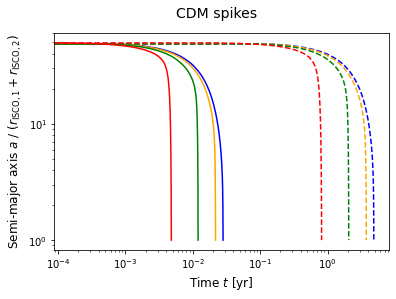

In [18]:
# Plot the results for CDM

color_list = ["blue","orange","green","red"]
for i in range(len(e0)):
    plt.loglog(ev_ecc_CDM[2*i].t/c.year_to_pc, ev_ecc_CDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = '$e_0 = $' + str(e0[i]), color = color_list[i])
    plt.loglog(ev_ecc_CDM[2*i+1].t/c.year_to_pc, ev_ecc_CDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), linestyle = "dashed", color = color_list[i])

plt.loglog(1e-1, 1e1, label=r"$m_1 = m_2 = 10^6 \, M_{\odot}$ ", linestyle="solid", color="black")
plt.loglog(1e-1, 1e1, label=r"$m_1 = m_2 = 10^8 \, M_{\odot}$ ", linestyle="dashed", color="black")

plt.suptitle("CDM spikes", y=0.97, fontsize=14)    
#plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=12)
plt.xlabel("Time $t$ [yr]", fontsize=12); plt.ylabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=12)
plt.show()

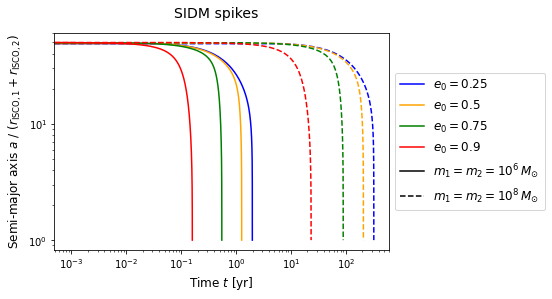

In [19]:
# Plot the results for SIDM
#plt.loglog(ev_SIDM.t/c.year_to_pc,ev_SIDM.R/(sp.r_isco_1()+sp.r_isco_2()), label='$e = 0$')
for i in range(len(e0)):
    plt.loglog(ev_ecc_SIDM[2*i].t/c.year_to_pc, ev_ecc_SIDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), label = '$e_0 = $' + str(e0[i]), color = color_list[i])
    plt.loglog(ev_ecc_SIDM[2*i+1].t/c.year_to_pc, ev_ecc_SIDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), linestyle = "dashed", color = color_list[i])
    
plt.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^6 \, M_{\odot}$ ", linestyle="solid", color="black")
plt.loglog(1e1, 1e1, label=r"$m_1 = m_2 = 10^8 \, M_{\odot}$ ", linestyle="dashed", color="black") 

plt.suptitle("SIDM spikes", y=0.97, fontsize=14)  
plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=12); plt.xlabel("Time $t$ [yr]", fontsize=12); plt.ylabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=12)
plt.show()

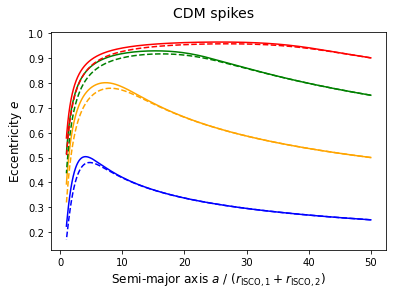

In [21]:
# Plot eccentricity vs. semi-major axis for CDM
for i in range(len(e0)):
    plt.plot(ev_ecc_CDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), ev_ecc_CDM[2*i].e, label = '$e_0 = $' + str(e0[i]), color = color_list[i])
    plt.plot(ev_ecc_CDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), ev_ecc_CDM[2*i+1].e, linestyle = "dashed", color = color_list[i])

plt.plot(20, 0.5, label=r"$m_1 = m_2 = 10^6 \, M_{\odot}$ ", linestyle="solid", color="black")
plt.plot(20, 0.5, label=r"$m_1 = m_2 = 10^8 \, M_{\odot}$ ", linestyle="dashed", color="black")    
    
plt.suptitle("CDM spikes", y=0.97, fontsize=14)
#plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=12)
plt.xlabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=12); plt.ylabel("Eccentricity $e$", fontsize=12)
plt.show()

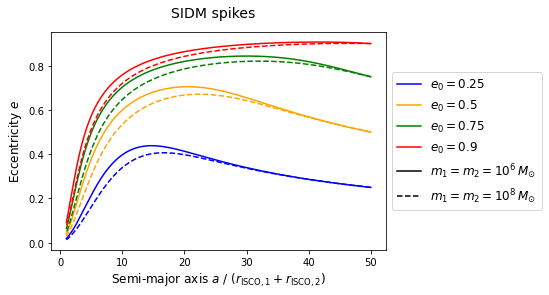

In [22]:
# Plot eccentricity vs. semi-major axis for SIDM
for i in range(len(e0)):
    plt.plot(ev_ecc_SIDM[2*i].a/(sp_list[0].r_isco_1()+sp_list[0].r_isco_2()), ev_ecc_SIDM[2*i].e, label = '$e_0 = $' + str(e0[i]), color = color_list[i])
    plt.plot(ev_ecc_SIDM[2*i+1].a/(sp_list[1].r_isco_1()+sp_list[1].r_isco_2()), ev_ecc_SIDM[2*i+1].e, linestyle = "dashed", color = color_list[i])

plt.plot(20, 0.5, label=r"$m_1 = m_2 = 10^6 \, M_{\odot}$ ", linestyle="solid", color="black")
plt.plot(20, 0.5, label=r"$m_1 = m_2 = 10^8 \, M_{\odot}$ ", linestyle="dashed", color="black")   

plt.suptitle("SIDM spikes", y=0.97, fontsize=14)
plt.legend(loc="center left",  bbox_to_anchor=(1, 0.5), fontsize=12); plt.xlabel("Semi-major axis $a$ / ($r_{\mathrm{ISCO,1}}+r_{\mathrm{ISCO,2}}$)", fontsize=12); plt.ylabel("Eccentricity $e$", fontsize=12)
#plt.savefig('1-e_a_eccentric_orbits_SIDM.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
a0 = 50. * (sp.r_isco_1()+sp.r_isco_2())
e0 = np.array([0.25, 0.5])

a_fin = (sp.r_isco_1()+sp.r_isco_2())

ev_ecc_CDM_ = []
ev_ecc_SIDM_ = []

for i in e0:
    ev_ecc_CDM_.append(SMBHBpy.inspiral.Classic.Evolve(sp_CDM, a0, e_0=i,  a_fin = a_fin))
    ev_ecc_SIDM_.append(SMBHBpy.inspiral.Classic.Evolve(sp_SIDM, a0, e_0=i,  a_fin = a_fin))

Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 6.3659s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.25  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 4.8486s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 13.9419s
Evolving from  50.0  to  1.0 r_isco_1+r_isco_2  with initial eccentricity 0.5  with  Options: dissipative Forces emplyed {GWLoss, DynamicalFriction, }, accuracy = 1.0e-12
A termination event occurred.
 -> Evolution took 7.0805s


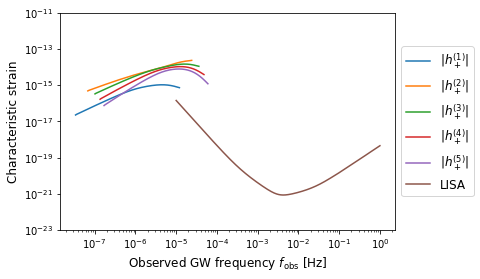

In [50]:
# Plot the first five harmonics for e0 = e0[p] and CDM spikes
n_comp = 5
p = 0

wfs_CDM = [SMBHBpy.waveform.h_n(n, sp_CDM, ev_ecc_CDM_[p], acc=1e-13) for n in range(1, n_comp+1)]

for i in range(len(wfs_CDM)):
    plt.loglog(wfs_CDM[i][0]/c.hz_to_invpc, 2.*wfs_CDM[i][0]*np.abs(wfs_CDM[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

# LISA:    
Lisa = SMBHBpy.detector.Lisa()
f_gw_LISA = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 1000)
plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12); plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Characteristic strain", fontsize=12); plt.ylim(bottom=1e-23, top=1e-11); plt.show()

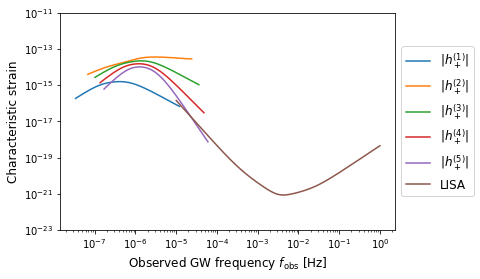

In [51]:
# Plot the first five harmonics for e0 = e0[p] and SIDM spikes
n_comp = 5
p = 0

wfs_SIDM = [SMBHBpy.waveform.h_n(n, sp_SIDM, ev_ecc_SIDM_[p], acc=1e-13) for n in range(1, n_comp+1)]

for i in range(len(wfs_SIDM)):
    plt.loglog(wfs_SIDM[i][0]/c.hz_to_invpc, 2.*wfs_SIDM[i][0]*np.abs(wfs_SIDM[i][1]), label=r"$|h^{(" + str(i+1) + ")}_+|$")

plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12); plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Characteristic strain", fontsize=12); plt.ylim(bottom=1e-23, top=1e-11); plt.show()

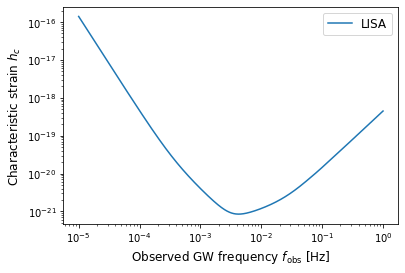

In [53]:
#LISA
Lisa = SMBHBpy.detector.Lisa()
f_gw_LISA = np.geomspace(Lisa.Bandwith()[0], Lisa.Bandwith()[1], 1000)
plt.xlabel("Observed GW frequency $f_{\mathrm{obs}}$ [Hz]", fontsize=12); plt.ylabel("Characteristic strain $h_c$", fontsize=12)
plt.loglog(f_gw_LISA/c.hz_to_invpc, Lisa.NoiseStrain(f_gw_LISA), label='LISA')
plt.legend(fontsize=12); plt.show()

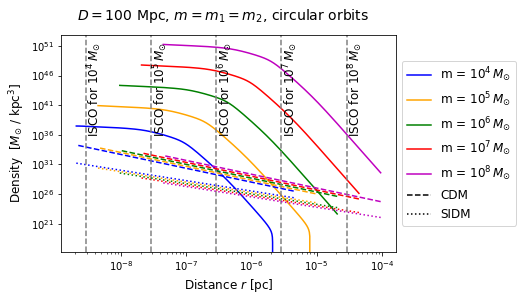

In [54]:
# Upper limit for matter density using LISA's sensitivity curve
mass_array = np.array([10**4,10**5,10**6,10**7,10**8])*c.solar_mass_to_pc
smallest_exponent = 4
r_infl_array = 2*mass_array/sigma**2
Lambda_array = b_max/r_infl_array
iota = np.pi/2
D_array = np.array([100, 500, 1000])*1e6
z_array = 2.3e-10*D_array
h_c_LISA = Lisa.NoiseStrain(f_gw_LISA)
f_LISA = f_gw_LISA

A_array = np.zeros(len(mass_array))
B_array = np.zeros(len(mass_array))

color = ["blue", "orange", "green", "red", "m"]

j = 0
D = D_array[j]
z = z_array[j]

for i in range(len(mass_array)):
    A_array[i] = 1./3.*1./2**(2./3.)*1./(np.log(Lambda_array[i]))*((1+(np.cos(iota))**2)/D)**2*((1+z)**16*mass_array[i]**10*np.pi**4)**(1./3.)
    B_array[i] = 1./5.*1./(np.log(Lambda_array[i]))*(2**8*(1+z)**11*mass_array[i]**5*np.pi**8)**(1./3.)
    
for i in range(len(mass_array)):
    m = mass_array[i]
    r = (2*m/(f_LISA*(1+z)*np.pi)**2)**(1./3.)
    rho_DM_array = A_array[i]*f_LISA**(10./3.)/(h_c_LISA**2)-B_array[i]*f_LISA**(11./3.)
    exponent = smallest_exponent+i
    plt.loglog(r, rho_DM_array/c.solar_mass_to_pc*1e9, label = f"m = $10^{{{exponent}}}\, M_{{\odot}}$", color = color[i])


#####

r_isco_array = 6*mass_array

for i in range(len(mass_array)):
    m = mass_array[i]
    r = (2*m/(f_LISA*(1+z)*np.pi)**2)**(1./3.)
    exponent = smallest_exponent+i
    r_sp = 0.2*m/sigma**2
    rho_sp_CDM = (3-7/3)*0.2**(3-7/3)*m/(2*np.pi*r_sp**3)
    rho_sp_SIDM = (3-7/4)*0.2**(3-7/4)*m/(2*np.pi*r_sp**3)
    rho_CDM = rho_sp_CDM * (r_sp/r)**(7/3)
    rho_SIDM = rho_sp_SIDM * (r_sp/r)**(7/4)
    plt.loglog(r,rho_CDM/c.solar_mass_to_pc*1e9, linestyle = '--', color = color[i])
    plt.loglog(r,rho_SIDM/c.solar_mass_to_pc*1e9, linestyle = ':', color = color[i])
    plt.axvline(x=r_isco_array[i], color='grey', linestyle='--')
    plt.text(r_isco_array[i], 0.5*1e36, f'ISCO for $10^{{{exponent}}}\, M_{{\odot}}$', rotation='vertical', verticalalignment='bottom', fontsize = 12)

plt.loglog(1e-6, 1e30, label="CDM", linestyle="--", color="black")
plt.loglog(1e-6, 1e30, label="SIDM", linestyle=":", color="black")

plt.suptitle("$D = 100$ Mpc, $m = m_1 = m_2$, circular orbits", y=0.975, fontsize=14)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12); plt.xlabel("Distance $r$ [pc]", fontsize=12); plt.ylabel("Density  [$M_{\odot}$ / kpc$^3$]", fontsize=12)
plt.show()